In [1]:
%matplotlib inline
import os
import os.path as osp
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision as tv

from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt
import math

import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch.backends.cudnn as cudnn

import cv2
from ssd import build_ssd
import random

from data import VOCDetection, VOC_ROOT, VOCAnnotationTransform
from data import VOC_CLASSES as labels

In [2]:
if sys.version_info[0] == 2:
    import xml.etree.cElementTree as ET
else:
    import xml.etree.ElementTree as ET

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [4]:
VOC_ROOT= 'D:\\Spring 19\\ECE 285\VOC\\VOCdevkit\\'

In [5]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [6]:
net = build_ssd('test', 300, 21)    # initialize SSD
net.load_weights('ssd300_mAP_77.43_v2.pth')

C:\Users\karth\ECE 285\Project_SSD\ssd.py:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.priors = Variable(self.priorbox.forward(), volatile=True)


Loading weights into state dict...
Finished!


In [7]:
class NNRegressor(nt.NeuralNetwork):
    
    def __init__(self):
        super(NNRegressor, self).__init__()
        self.mse = nn.MSELoss()
        
    def criterion(self, y, d):
        return self.mse(y, d)

In [8]:
class DUDnCNN(NNRegressor):
    
    def __init__(self, D, C=64):
        super(DUDnCNN, self).__init__()
        self.D = D
        self.conv = nn.ModuleList()
        
        self.conv.append(nn.Conv2d(3, C, 3, padding=1)) # Padding = (3-1)/2 ==> 1
        
        for k in range(D):
            if (k == D/2):
                l = 1
            elif(k > D/2):
                l += 2
            else:
                l = 0
            
            dil = int(1 + 2**(k-l) -1)
            self.conv.append(nn.Conv2d(C, C, 3, padding=dil, dilation=dil))
        
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C, C))
    
        for k in range(len(self.conv)-1):
            self.conv[k].weight.data = nn.init.kaiming_normal_(self.conv[k].weight.data, nonlinearity='relu')
        
        for k in range(D):    
            self.bn[k].weight.data = nn.init.constant_(self.bn[k].weight.data, 1.25 * np.sqrt(C))
        
    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for k in range(D):
            torch.backends.cudnn.benchmark=True  # Q20 
            h = self.conv[k+1](h)
            torch.backends.cudnn.benchmark=False  # Q20
            h = F.relu(self.bn[k](h))
        
        y = self.conv[D+1](h) + x
        return y

In [9]:
net_DUDnCNN = torch.load('denNet.pt')

In [10]:
def readImage(path, noisy=False, plot=False):
    orig = cv2.imread(impath, cv2.IMREAD_COLOR)
    rgb_image = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    orig_shape = orig.shape
    noisy_image = None
    
    if noisy:
        noisy_orig = orig[...,::-1]/255.0
        noise =  np.random.normal(loc=0, scale=1, size=noisy_orig.shape)
        noise2 = (noise - noise.min())/(noise.max()-noise.min())

        # noise overlaid over image
        noisy = np.clip((noisy_orig + noise*0.2),0,1)
        noisy2 = np.clip((noisy_orig + noise*0.4),0,1)
        orig = noisy2*255.0
        noisy_image = orig
        
    x = cv2.resize(orig, (300, 300)).astype(np.float32)
    x -= (104.0, 117.0, 123.0)
    x = x.astype(np.float32)
    x = x[:, :, ::-1].copy()
    x = torch.from_numpy(x).permute(2, 0, 1)

    if plot:
        plt.figure(figsize=(10,5))
        plt.subplot(121)
        plt.imshow(rgb_image)
        plt.subplot(122)
        plt.imshow((x*255).astype(np.uint8))

    return x, rgb_image, noisy_image

In [21]:
def getDenoised(noisy_image, net_DUDnCNN):
    denoised = noisy_image
    im = Image.fromarray(np.uint8(denoised))
    image_size = (300,300)

    # declare a tranform to convert the image to a tensor and normalize it between [-1, 1]
    transform = tv.transforms.Compose([tv.transforms.Resize(image_size),
                                tv.transforms.ToTensor(), tv.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]) 
    
    denoised = transform(im).unsqueeze(0)
    y = (net_DUDnCNN.forward(denoised)).detach()
    denoised = y[0].permute(1,2,0).numpy()
    denoised = 255.0*((denoised+1)/2)
    
    im2 = Image.fromarray(np.uint8(denoised))
    tran = tv.transforms.Compose([tv.transforms.Resize((rgb_image.shape[0],rgb_image.shape[1])), tv.transforms.ToTensor()])
    denoised = tran(im2)
    denoised = (tran(im2)*255.0).permute(1,2,0).numpy()

    x = cv2.resize(denoised, (300, 300)).astype(np.float32)
    x -= (104.0, 117.0, 123.0)
    x = x.astype(np.float32)
    x = x[:, :, ::-1].copy()
    x = torch.from_numpy(x).permute(2, 0, 1)
    
    return x, denoised

In [22]:
VIDEO_ROOT = 'D:\\Spring 19\\ECE 285\\Project_SSD\\video\\600_frames\\'

In [23]:
image_name = random.choice(os.listdir(VIDEO_ROOT))
impath = VIDEO_ROOT + image_name
print(impath)

D:\Spring 19\ECE 285\Project_SSD\video\600_frames\NYC00543.jpg


#### Get noisy image

In [24]:
x,rgb_image,noisy_image = readImage(impath, noisy=True)

#### Get denoised image using DUDnCNN

In [34]:
x, denoised_image = getDenoised(noisy_image, net_DUDnCNN)

In [35]:
img = x.unsqueeze(0)
y = net(img)

### CV2 SAVE

<Figure size 720x720 with 0 Axes>

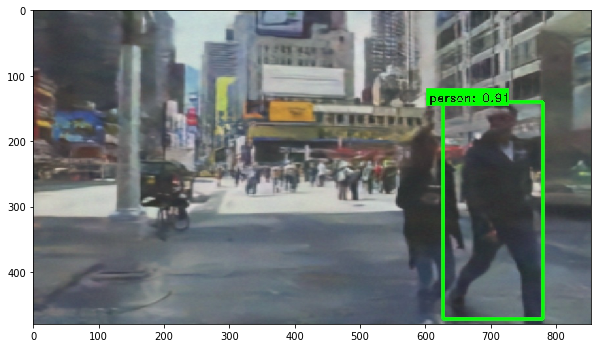

In [46]:
top_k=10

figure = plt.figure(figsize=(10,10))

detections = y.data

# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)

for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        
        if j==0:
            im = cv2.rectangle(denoised_image,(pt[0],pt[1]),(pt[2], pt[3]),(0,255,0),3)
        else:
            im = cv2.rectangle(im,(pt[0],pt[1]),(pt[2], pt[3]),(0,255,0),3)
        
        im = cv2.rectangle(im,(int(pt[0]-25),int(pt[1]-20)),(int(pt[0]+100), int(pt[1]+5)),(0,255,0),-1)
        
        text_coor = int(pt[0]-21)
        if text_coor<0:
            text_coor = 2
        im = cv2.putText(im,display_txt,(text_coor,pt[1]), cv2.FONT_HERSHEY_DUPLEX, 0.6,(0,0,0),1,cv2.LINE_AA)
        j+=1
        
plt.figure(figsize=(10,10))
cv2.imwrite("sample.jpg", temp)
im = cv2.imread("sample.jpg")
plt.imshow(im)

### FRAMES

In [43]:
VIDEO_OUT_ROOT = 'D:\\Spring 19\\ECE 285\\Project_SSD\\video\\600_frames_out_DENOISED2\\'

In [20]:
figure = plt.figure(figsize=(10,10))
for filename in os.listdir(VIDEO_ROOT):
    impath = VIDEO_ROOT + str(filename)
    print("Working on " + str(filename))
    
    x,rgb_image,noisy_image = readImage(impath, noisy=True)
    x, denoised_image = getDenoised(noisy_image, net_DUDnCNN)
    
    img = x.unsqueeze(0)     # wrap tensor in Variable
    y = net(img)
    
    top_k=10

    detections = y.data
    # scale each detection back up to the image
    scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
    for i in range(detections.size(1)):
        j = 0
        while detections[0,i,j,0] >= 0.6:
            score = detections[0,i,j,0]
            label_name = labels[i-1]
            display_txt = '%s: %.2f'%(label_name, score)
            pt = (detections[0,i,j,1:]*scale).cpu().numpy()
            coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1

            if j==0:
                im = cv2.rectangle(denoised_image,(pt[0],pt[1]),(pt[2], pt[3]),(0,255,0),3)
            else:
                im = cv2.rectangle(im,(pt[0],pt[1]),(pt[2], pt[3]),(0,255,0),3)

            im = cv2.rectangle(im,(int(pt[0]-25),int(pt[1]-20)),(int(pt[0]+100), int(pt[1]+5)),(0,255,0),-1)

            text_coor = int(pt[0]-21)
            if text_coor<0:
                text_coor = 2
            im = cv2.putText(im,display_txt,(text_coor,pt[1]), cv2.FONT_HERSHEY_DUPLEX, 0.6,(0,0,0),1,cv2.LINE_AA)
            j+=1

    cv2.imwrite((VIDEO_OUT_ROOT+str(filename)), im)

Working on NYC00022.jpg
Working on NYC00023.jpg
Working on NYC00024.jpg
Working on NYC00025.jpg
Working on NYC00026.jpg
Working on NYC00027.jpg
Working on NYC00028.jpg
Working on NYC00029.jpg
Working on NYC00030.jpg
Working on NYC00031.jpg
Working on NYC00032.jpg
Working on NYC00033.jpg
Working on NYC00034.jpg
Working on NYC00035.jpg
Working on NYC00036.jpg
Working on NYC00037.jpg
Working on NYC00038.jpg
Working on NYC00039.jpg
Working on NYC00040.jpg
Working on NYC00041.jpg
Working on NYC00042.jpg
Working on NYC00043.jpg
Working on NYC00044.jpg
Working on NYC00045.jpg
Working on NYC00046.jpg
Working on NYC00047.jpg
Working on NYC00048.jpg
Working on NYC00049.jpg
Working on NYC00050.jpg
Working on NYC00051.jpg
Working on NYC00052.jpg
Working on NYC00053.jpg
Working on NYC00054.jpg
Working on NYC00055.jpg
Working on NYC00056.jpg
Working on NYC00057.jpg
Working on NYC00058.jpg
Working on NYC00059.jpg
Working on NYC00060.jpg
Working on NYC00061.jpg
Working on NYC00062.jpg
Working on NYC00

<Figure size 720x720 with 0 Axes>